In [43]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

import os
import sys
import yaml
from tqdm import tqdm
import scipy.io as sio
import matplotlib.pyplot as plt

# customized packages
import dataset
import math
import utils
from mlp import projector


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
############ color dataset ################
# N = 48
# color_dataset = dataset.Dataset(dataset_type='Color',color_path='./CPdata.mat', N=N)
# color_data = color_dataset.getAllData()

# items = color_data['X']
# observations = color_data['S']
# true_y = color_data['Y']
# true_M = color_data['M']
# true_u = color_data['U']

# obs_train, obs_test, Y_train, Y_test = color_dataset.getTrainTestSplit(train_size=0.75)

############ normal dataset ################
# d: ambient dimension
# r: metric rank
# n: number of items
# N: number of users
# m: number of measurements per user
# noise_type: type of noise in measurement model, from {'none', 'logistic'}
# noise_param: noise parameter, if relevant (in 'logistic' noise, is noise scaling parameter)
# X: X: if None, generates new data. Else, specifies item matrix

# default setting
# pms = {'d': 2, 'r': 2, 'n': 100,'N': 3, 'm':30, 'noise_type':'none', 'noise_param':None, 'X':None}

# a little bit complex setting
pms = {'d': 128, 'r': 128, 'n': 1000,'N': 100, 'm':300, 'noise_type':'none', 'noise_param':None, 'X':None}

N = pms['N']

# train_frac = 0.5 # train/test split fraction, specifically equal to # train points / total data
# n_splits =  5 # k-fold number of splits (defunct)
# loss_fun = 'logistic' # loss function for ERM
# use_oracle = True # use oracle hyperparameters
# hyper_sweep = [] # (relative) hyperparameter magnitudes for hyperparameter sweep
# m_train = 300 # number of training comparisons per user
# m_train_res = 30

normal_dataset = dataset.Dataset(dataset_type='Normal', d=pms['d'], 
                                 r=pms['d'], n=pms['n'], 
                                 N=pms['N'], m=pms['m'], 
                                 noise_type=pms['noise_type'], 
                                 noise_param=pms['noise_param'], X=None)

normal_data = normal_dataset.getAllData()

items = normal_data['X']
observations = normal_data['S']
true_y = normal_data['Y']
true_M = normal_data['M']
true_u = normal_data['U']

obs_train, obs_test, Y_train, Y_test = normal_dataset.getTrainTestSplit(train_size=0.75)

In [50]:
# initialize both M and u_s
net = projector(feature_dim=2, num_layer=1, num_class=2, bias_ind=False)
us = []
for i in range(N):
    us.append(torch.randn(2,requires_grad=True))

In [51]:
# true prediction (just for verification) original version
delta_s = []
pred_ys = []
for obs in observations:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    delta = (items[:,x_i]-true_u[:,user_id]).T @ true_M @ (items[:,x_i]-true_u[:,user_id]) - (items[:,x_j]-true_u[:,user_id]).T @ true_M @ (items[:,x_j]-true_u[:,user_id])
    delta_s.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys.append(pred_y)
assert np.all(pred_ys == true_y)

In [53]:
true_L = np.linalg.cholesky(true_M)  # true_M = L @ L.T
with torch.no_grad():
    net.layers.weight.copy_(torch.Tensor(true_L.T))

# true prediction (just for verification) but pytorch version
delta_s_torch = []
pred_ys_torch = []
for obs in observations:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    x_i, x_j = torch.Tensor(items[:,x_i]), torch.Tensor(items[:,x_j])
    u = torch.Tensor(true_u[:,user_id])
    with torch.no_grad():
        ele_1 = net(x_i-u)
        ele_2 = net(x_j-u)
    delta = ele_1.T @ ele_1 - ele_2.T @ ele_2
    delta_s_torch.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys_torch.append(pred_y)

assert np.all(pred_ys_torch == true_y)

# Attempt 1: update only M but no user update! (use the true u here)

In [54]:
# attempt 1: update only M but no user update! (use the true u here)
epochs = 100
bs = 4
lr = 1e-3
momentum = 0.9
weight_decay = 0.001

############ initialize both M and u_s ################
net = projector(feature_dim=2, num_layer=1, num_class=2, bias_ind=False)
us = []
for i in range(N):
    us.append(torch.randn(3,requires_grad=True))


############ define loss and optimizer ################
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    """
    Hinge loss for binary classification.

    Parameters:
    outputs (torch.Tensor): Output from the model (before activation function like sigmoid).
    targets (torch.Tensor): Ground truth labels, expected to be +1 or -1.

    Returns:
    torch.Tensor: Calculated hinge loss.
    """
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

loss_fn = hinge_loss
optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)

############ define dataloader ################
class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]
    
train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

############ define training function ################
def train(net,optimizer,loss_fn,train_loader,test_loader,epochs):
    train_stats = {
        'train_loss_per_batch_record': [],
        'train_accu_record': [],
        'test_loss_per_batch_record': [],
        'test_accu_record': [],
        'relative_metric_error_record': [],
    }

    for ep in range(epochs):
        for x,y in train_loader:
            optimizer.zero_grad()

            user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
            # print(x)
            # print(user_ids)
            # print(x_is)
            # print(x_js)
            # print(y)

            x_is, x_js = torch.Tensor(items[:,x_is]), torch.Tensor(items[:,x_js])
            us = torch.Tensor(true_u[:,user_ids])
            # print('x_is', x_is)
            # print('x_js', x_js)
            # print('us', us)

            x_is_minus_us = (x_is - us).T
            x_js_minus_us = (x_js - us).T
            
            ele_1 = net(x_is_minus_us)
            ele_2 = net(x_js_minus_us)

            # print(ele_1.shape)
            # print(ele_2.shape)

            delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
            
            # print(delta)
            acc_batch = torch.sum((delta * y)>0)
            # print(f'prediction_accu: {acc_batch/bs}')
            
            L = net.layers.weight
            relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
            train_stats['relative_metric_error_record'].append(relative_metric_error.item())

            loss = loss_fn(delta,y)
            # print(loss)

            train_stats['train_loss_per_batch_record'].append(loss.item())
            train_stats['train_accu_record'].append(acc_batch/bs)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        
        val_stat = val(net,loss_fn,test_loader)
        train_stats['test_loss_per_batch_record'].extend(val_stat['test_loss_per_batch'])
        train_stats['test_accu_record'].append(val_stat['test_accu'])
    return train_stats

############ define val function ################
def val(net,loss_fn,test_loader):
    total_val_samples = len(test_dataloader.dataset)
    val_stat = {
        'test_correct': 0,
        'test_loss_per_batch': [],
        'test_accu': 0
    }

    with torch.no_grad():
        for x,y in test_loader:
            user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
            x_is, x_js = torch.Tensor(items[:,x_is]), torch.Tensor(items[:,x_js])
            us = torch.Tensor(true_u[:,user_ids])
            x_is_minus_us = (x_is - us).T
            x_js_minus_us = (x_js - us).T
            ele_1 = net(x_is_minus_us)
            ele_2 = net(x_js_minus_us)
            delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
            acc_batch = torch.sum((delta * y)>0)
            loss = loss_fn(delta,y)

            val_stat['test_correct'] += acc_batch.item()
            val_stat['test_loss_per_batch'].append(loss.item())
    
    val_stat['test_accu'] = val_stat['test_correct'] / total_val_samples

    return val_stat






In [112]:
# only for code debugging, do not use it when train from scratch!
# this line will assign the true L to the neural network

true_L = np.linalg.cholesky(true_M)  # true_M = L @ L.T
with torch.no_grad():
    net.layers.weight.copy_(torch.Tensor(true_L.T))

In [130]:
# loss_record = []
# accu_record = []
# relative_metric_error_record = []

# for ep in range(epochs):
#     for x,y in train_dataloader:
#         optimizer.zero_grad()

#         user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
#         # print(x)
#         # print(user_ids)
#         # print(x_is)
#         # print(x_js)
#         # print(y)

#         x_is, x_js = torch.Tensor(items[:,x_is]), torch.Tensor(items[:,x_js])
#         us = torch.Tensor(true_u[:,user_ids])
#         # print('x_is', x_is)
#         # print('x_js', x_js)
#         # print('us', us)

#         x_is_minus_us = (x_is - us).T
#         x_js_minus_us = (x_js - us).T
        
#         ele_1 = net(x_is_minus_us)
#         ele_2 = net(x_js_minus_us)

#         # print(ele_1.shape)
#         # print(ele_2.shape)

#         delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
        
#         # print(delta)
#         acc_batch = torch.sum((delta * y)>0)
#         # print(f'prediction_accu: {acc_batch/bs}')
        
#         L = net.layers.weight
#         relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
#         relative_metric_error_record.append(relative_metric_error.item())

#         loss = loss_fn(delta,y)
#         # print(loss)

#         loss_record.append(loss.item())
#         accu_record.append(acc_batch/bs)
#         # Backward and optimize
#         loss.backward()
#         optimizer.step()

# Main

In [14]:
# this line is the main training function, include the training and testing part.

train_stats = train(net, optimizer, loss_fn, train_dataloader, test_dataloader, epochs)

Text(0, 0.5, 'train_loss_per_batch_record')

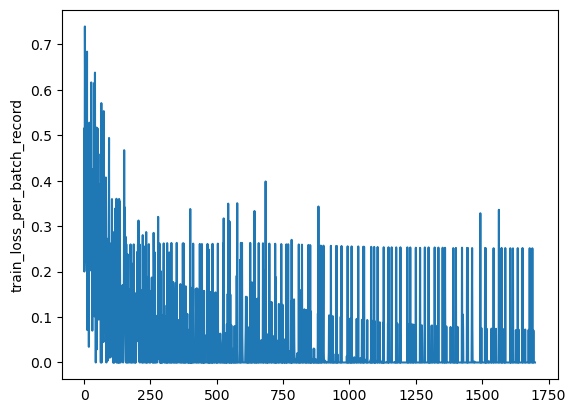

In [15]:
plt.plot(train_stats['train_loss_per_batch_record'])
plt.ylabel('train_loss_per_batch_record')

Text(0, 0.5, 'train_accu_record')

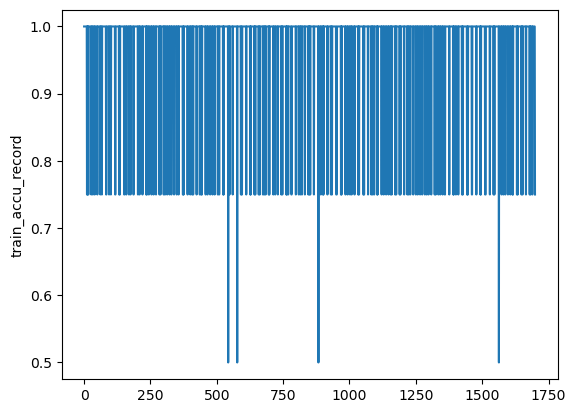

In [16]:
plt.plot(train_stats['train_accu_record'])
plt.ylabel('train_accu_record')

Text(0, 0.5, 'test_accu_record')

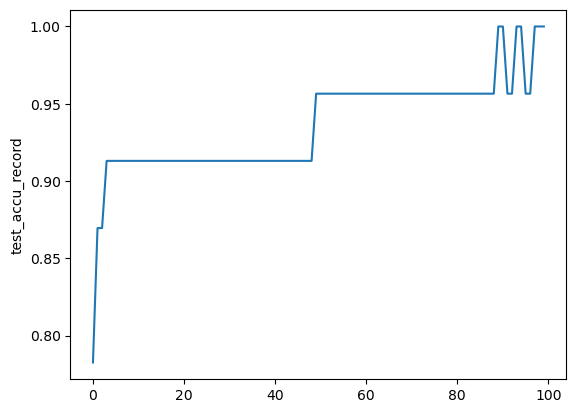

In [17]:
plt.plot(train_stats['test_accu_record'])
plt.ylabel('test_accu_record')

Text(0, 0.5, 'test_loss_per_batch_record')

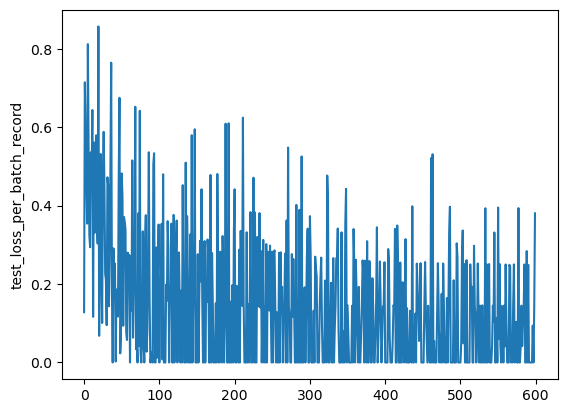

In [18]:
plt.plot(train_stats['test_loss_per_batch_record'])
plt.ylabel('test_loss_per_batch_record')

# Attempt 2: update both M and U_s

In [142]:
# attempt 2: update both M and u_s
epochs = 100
bs = 32
lr = 1e-2
momentum = 0.9
weight_decay = 0.001

############ initialize both M and u_s ################
net = projector(feature_dim=128, num_layer=1, num_class=128, bias_ind=False)
us = torch.randn((128,N),requires_grad=True)


############ define loss and optimizer ################
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    """
    Hinge loss for binary classification.

    Parameters:
    outputs (torch.Tensor): Output from the model (before activation function like sigmoid).
    targets (torch.Tensor): Ground truth labels, expected to be +1 or -1.

    Returns:
    torch.Tensor: Calculated hinge loss.
    """
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

loss_fn = hinge_loss
optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
optimizer.add_param_group({'params': us})

############ define dataloader ################
class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]
    
train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

############ define training function ################
def train(net,optimizer,loss_fn,train_loader,test_loader,epochs):
    train_stats = {
        'train_loss_per_batch_record': [],
        'train_accu_record': [],
        'test_loss_per_batch_record': [],
        'test_accu_record': [],
        'relative_metric_error_record': [],
        'relative_ideal_point_error_record': [],
    }

    tqdmr = tqdm(range(epochs))
    for ep in tqdmr:
        for x,y in train_loader:
            optimizer.zero_grad()
            user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
            # print(x)
            # print(user_ids)
            # print(x_is)
            # print(x_js)
            # print(y)
            
            x_is, x_js = torch.Tensor(items[:,x_is]), torch.Tensor(items[:,x_js])
            # us_k = torch.Tensor(true_u[:,user_ids])
            us_k_track = us[:,user_ids]
            # print('x_is', x_is)
            # print('x_js', x_js)

            x_is_minus_us = (x_is - us_k_track).T
            x_js_minus_us = (x_js - us_k_track).T
            
            ele_1 = net(x_is_minus_us)
            ele_2 = net(x_js_minus_us)

            # print(ele_1.shape)
            # print(ele_2.shape)

            delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
            
            # print(delta)
            acc_batch = torch.sum((delta * y)>0)
            # print(f'prediction_accu: {acc_batch/bs}')
            
            # calculate the relative_metric_error
            L = net.layers.weight
            relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
            train_stats['relative_metric_error_record'].append(relative_metric_error.item())

            # calculate the relative_ideal_point_error
            relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-us) / torch.norm(torch.tensor(true_u))).item()
            train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)

            loss = loss_fn(delta,y)
            # print(loss)

            train_stats['train_loss_per_batch_record'].append(loss.item())
            train_stats['train_accu_record'].append(acc_batch/bs)

            # # Backward and optimize
            loss.backward()
            optimizer.step()
            # break
        
        val_stat = val(net,loss_fn,test_loader)
        train_stats['test_loss_per_batch_record'].extend(val_stat['test_loss_per_batch'])
        train_stats['test_accu_record'].append(val_stat['test_accu'])
        tqdmr.set_postfix({'test_accu': val_stat['test_accu']})
        # break
    return train_stats

############ define val function ################
def val(net,loss_fn,test_loader):
    total_val_samples = len(test_dataloader.dataset)
    val_stat = {
        'test_correct': 0,
        'test_loss_per_batch': [],
        'test_accu': 0
    }

    with torch.no_grad():
        for x,y in test_loader:
            user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
            x_is, x_js = torch.Tensor(items[:,x_is]), torch.Tensor(items[:,x_js])
            us_k_track = us[:,user_ids]
            x_is_minus_us = (x_is - us_k_track).T
            x_js_minus_us = (x_js - us_k_track).T
            ele_1 = net(x_is_minus_us)
            ele_2 = net(x_js_minus_us)
            delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
            acc_batch = torch.sum((delta * y)>0)
            loss = loss_fn(delta,y)

            val_stat['test_correct'] += acc_batch.item()
            val_stat['test_loss_per_batch'].append(loss.item())
    
    val_stat['test_accu'] = val_stat['test_correct'] / total_val_samples

    return val_stat


In [143]:
train_stats = train_stats = train(net, optimizer, loss_fn, train_dataloader, test_dataloader, epochs)

100%|██████████| 100/100 [00:39<00:00,  2.56it/s, test_accu=0.817]


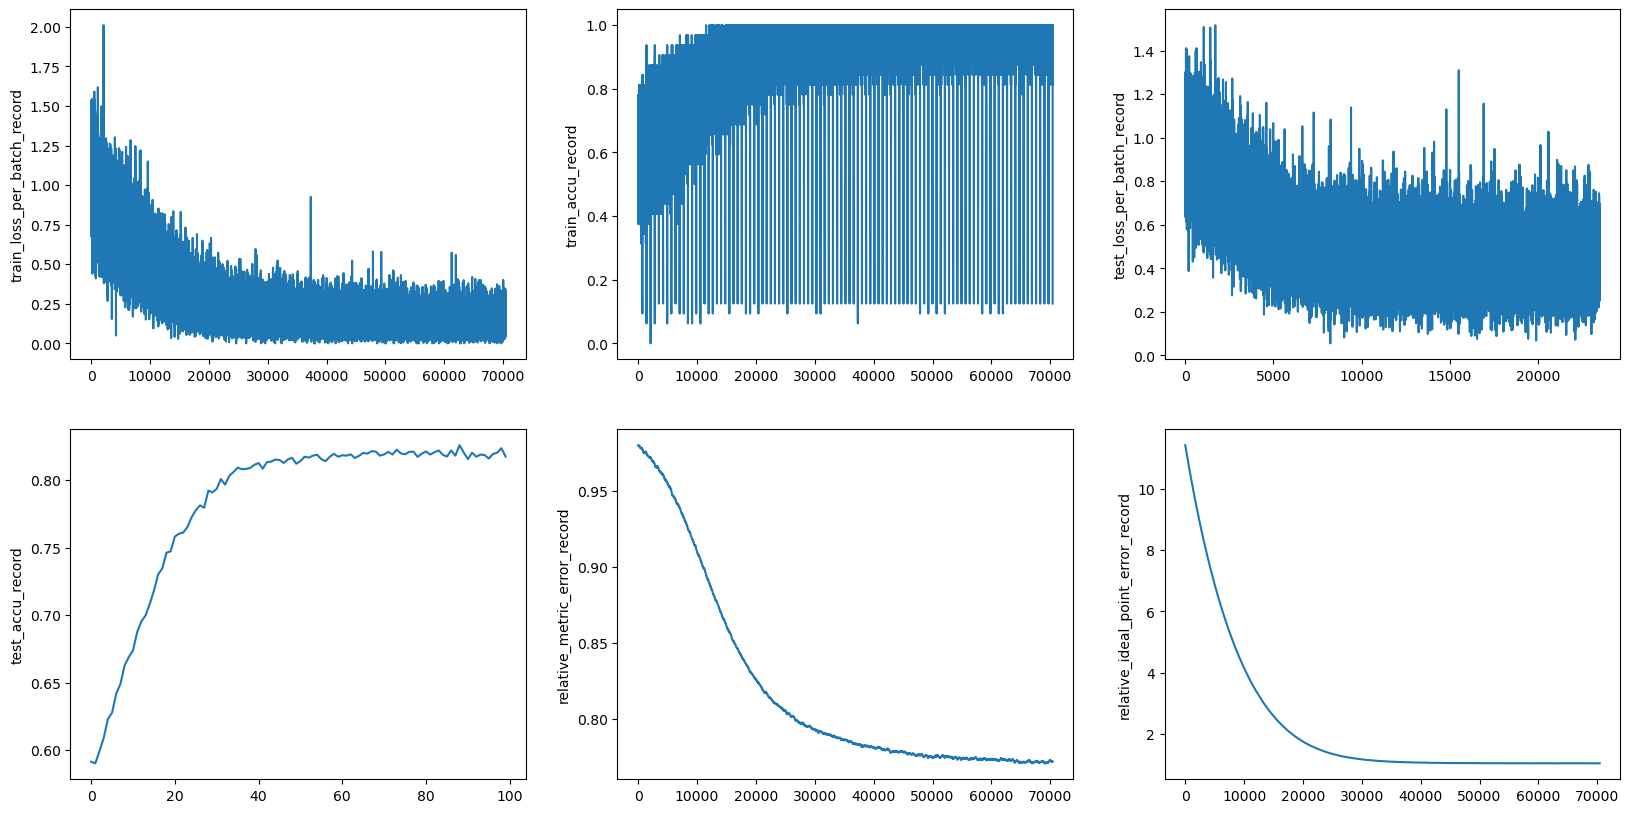

In [152]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)

# Only for simple test

In [127]:
# attempt 2: update both M and u_s
epochs = 100
bs = 32
lr = 1e-2
momentum = 0.9
weight_decay = 0.001

############ initialize both M and u_s ################
net = projector(feature_dim=128, num_layer=1, num_class=128, bias_ind=False)
# first way to create us
# us = []
# for i in range(N):
#     us.append(torch.randn(2,requires_grad=True))
# second way to create us
us = torch.randn((128,N),requires_grad=True)


############ define loss and optimizer ################
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    """
    Hinge loss for binary classification.

    Parameters:
    outputs (torch.Tensor): Output from the model (before activation function like sigmoid).
    targets (torch.Tensor): Ground truth labels, expected to be +1 or -1.

    Returns:
    torch.Tensor: Calculated hinge loss.
    """
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

loss_fn = hinge_loss
optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
optimizer.add_param_group({'params': us})

############ define dataloader ################
class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]
    
train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

In [128]:
train_stats = {
    'train_loss_per_batch_record': [],
    'train_accu_record': [],
    'test_loss_per_batch_record': [],
    'test_accu_record': [],
    'relative_metric_error_record': [],
    'relative_ideal_point_error_record': [],
}

tqdmr = tqdm(range(epochs))
for ep in tqdmr:
    for x,y in train_dataloader:
        optimizer.zero_grad()
        user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
        # print(x)
        # print(user_ids)
        # print(x_is)
        # print(x_js)
        # print(y)
        
        x_is, x_js = torch.Tensor(items[:,x_is]), torch.Tensor(items[:,x_js])
        # us_k = torch.Tensor(true_u[:,user_ids])
        us_k_track = us[:,user_ids]
        # print('x_is', x_is)
        # print('x_js', x_js)

        x_is_minus_us = (x_is - us_k_track).T
        x_js_minus_us = (x_js - us_k_track).T
        
        ele_1 = net(x_is_minus_us)
        ele_2 = net(x_js_minus_us)

        # print(ele_1.shape)
        # print(ele_2.shape)

        delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
        
        # print(delta)
        acc_batch = torch.sum((delta * y)>0)
        # print(f'prediction_accu: {acc_batch/bs}')
        
        # calculate the relative_metric_error
        L = net.layers.weight
        relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
        train_stats['relative_metric_error_record'].append(relative_metric_error.item())

        # calculate the relative_ideal_point_error
        relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-us) / torch.norm(torch.tensor(true_u))).item()
        train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)

        loss = loss_fn(delta,y)
        # print(loss)

        train_stats['train_loss_per_batch_record'].append(loss.item())
        train_stats['train_accu_record'].append(acc_batch/bs)

        # # Backward and optimize
        loss.backward()
        optimizer.step()
        # break
        
    val_stat = val(net,loss_fn,test_dataloader)
    train_stats['test_loss_per_batch_record'].extend(val_stat['test_loss_per_batch'])
    train_stats['test_accu_record'].append(val_stat['test_accu'])
    tqdmr.set_postfix({'test_accu': val_stat['test_accu']})
    # break
    

############ define val function ################
def val(net,loss_fn,test_loader):
    total_val_samples = len(test_dataloader.dataset)
    val_stat = {
        'test_correct': 0,
        'test_loss_per_batch': [],
        'test_accu': 0
    }

    with torch.no_grad():
        for x,y in test_loader:
            user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
            x_is, x_js = torch.Tensor(items[:,x_is]), torch.Tensor(items[:,x_js])
            us_k_track = us[:,user_ids]
            x_is_minus_us = (x_is - us_k_track).T
            x_js_minus_us = (x_js - us_k_track).T
            ele_1 = net(x_is_minus_us)
            ele_2 = net(x_js_minus_us)
            delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
            acc_batch = torch.sum((delta * y)>0)
            loss = loss_fn(delta,y)

            val_stat['test_correct'] += acc_batch.item()
            val_stat['test_loss_per_batch'].append(loss.item())
    
    val_stat['test_accu'] = val_stat['test_correct'] / total_val_samples

    return val_stat

100%|██████████| 100/100 [00:38<00:00,  2.58it/s, test_accu=0.819]


Text(0, 0.5, 'train_loss_per_batch_record')

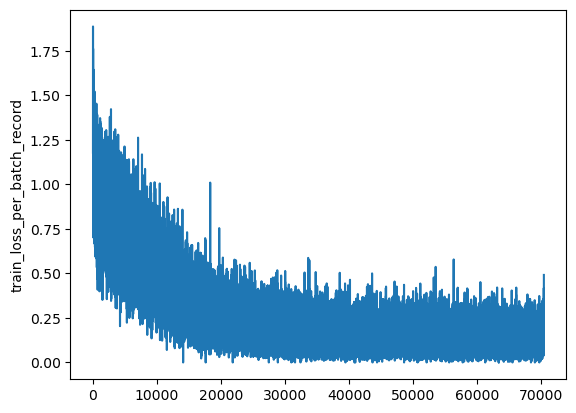

In [129]:
plt.plot(train_stats['train_loss_per_batch_record'])
plt.ylabel('train_loss_per_batch_record')

Text(0, 0.5, 'train_accu_record')

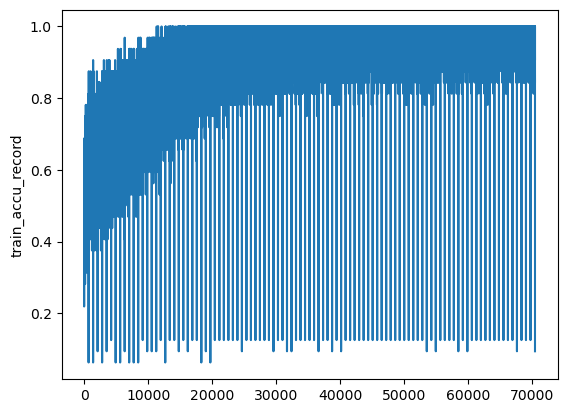

In [130]:
plt.plot(train_stats['train_accu_record'])
plt.ylabel('train_accu_record')

Text(0, 0.5, 'test_accu_record')

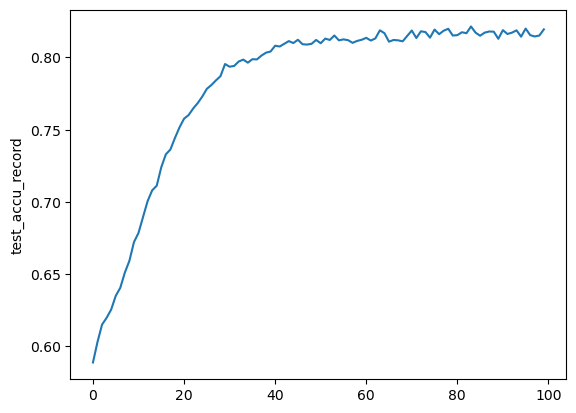

In [131]:
plt.plot(train_stats['test_accu_record'])
plt.ylabel('test_accu_record')

Text(0, 0.5, 'test_loss_per_batch_record')

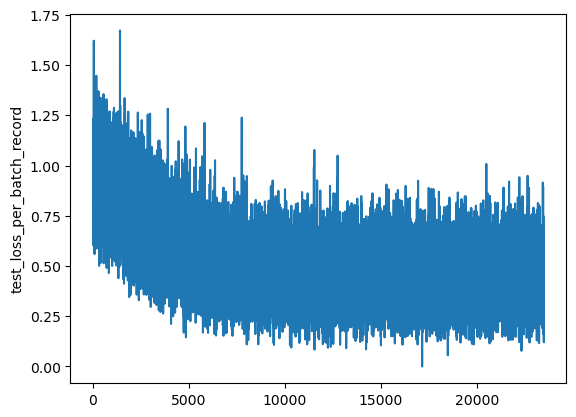

In [132]:
plt.plot(train_stats['test_loss_per_batch_record'])
plt.ylabel('test_loss_per_batch_record')

Text(0, 0.5, 'relative_metric_error_record')

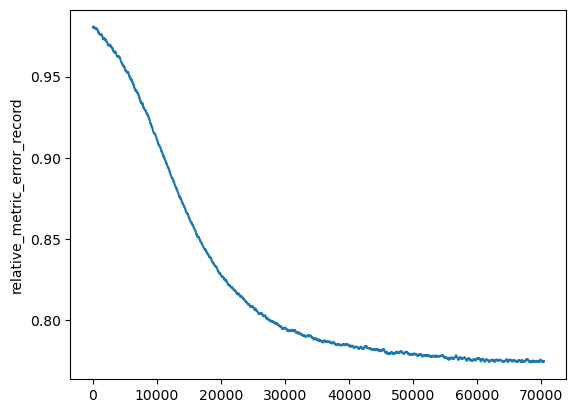

In [133]:
plt.plot(train_stats['relative_metric_error_record'])
plt.ylabel('relative_metric_error_record')

Text(0, 0.5, 'relative_ideal_point_error_record')

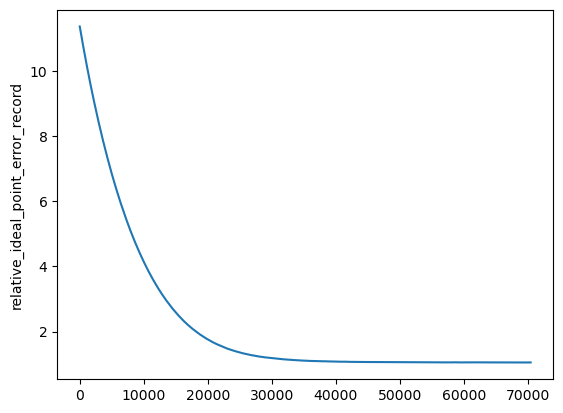

In [134]:
plt.plot(train_stats['relative_ideal_point_error_record'])
plt.ylabel('relative_ideal_point_error_record')